In [0]:
from pyspark.sql import Row
from pyspark.sql.functions import col, split, explode
from pyspark.mllib.recommendation import ALS, Rating
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, Normalizer
from pyspark.ml.clustering import BisectingKMeans

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType

# Step 1: Start Spark session
spark = SparkSession.builder \
    .appName("MovieLensReader") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

In [0]:
# STEP 1: Load Ratings Data 
ratings_path = "u.data"
raw_ratings = sc.textFile(ratings_path)

In [0]:
# Parse as (userId, movieId, rating)
ratings_rdd = raw_ratings.map(lambda line: line.split("\t")) \
                         .map(lambda x: Rating(int(x[0]), int(x[1]), float(x[2])))
# Train ALS Model
rank = 10  # Latent factors
numIterations = 10
lambda_ = 0.01
model = ALS.train(ratings_rdd, rank, numIterations, lambda_)


In [0]:
# STEP 2: Load Movie Data (Content-Based)
movies_path = "u.item"
raw_movies = sc.textFile(movies_path)

# Parse movie data (movieId, title, genres)
movies_rdd = raw_movies.map(lambda line: line.split("|")) \
                       .filter(lambda x: len(x) > 1) \
                       .map(lambda x: Row(movieId=int(x[0]), title=x[1], genres=x[2] if len(x) > 2 else "Unknown"))

movies_df = spark.createDataFrame(movies_rdd)

# Process Genres for Content-Based Filtering
movies_df = movies_df.withColumn("genres", split(col("genres"), "[|,]"))
movies_df = movies_df.withColumn("genre", explode(col("genres")))

In [0]:
# TF-IDF Feature Extraction
tokenizer = Tokenizer(inputCol="genre", outputCol="words")
words_data = tokenizer.transform(movies_df)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=50)
featurized_data = hashingTF.transform(words_data)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
rescaled_data = idf_model.transform(featurized_data)

# Normalize Features
normalizer = Normalizer(inputCol="features", outputCol="norm_features")
normalized_data = normalizer.transform(rescaled_data)

# Cluster Movies (Content-Based)
bkm = BisectingKMeans(featuresCol="norm_features", predictionCol="cluster", k=10)
model_bkm = bkm.fit(normalized_data)
clustered_movies = model_bkm.transform(normalized_data)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field norm_features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/databricks/python/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


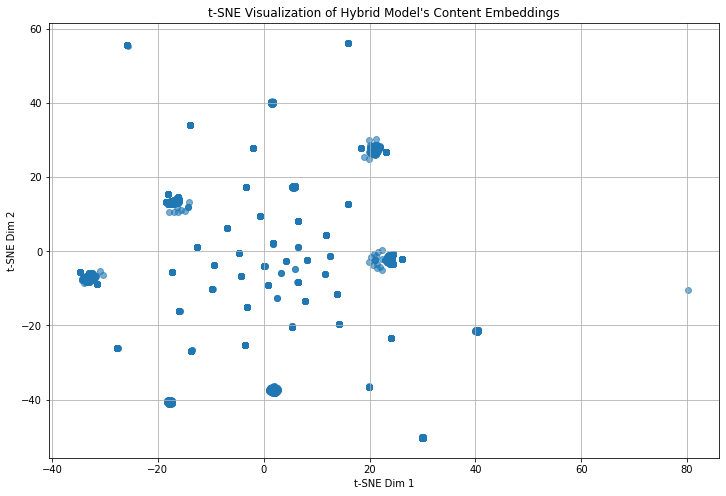

In [0]:
# t-SNE Visualization for HYBRID model's content features
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Convert norm_features to array
vector_df = normalized_data.select("movieId", "title", "norm_features").toPandas()
vector_df["norm_features"] = vector_df["norm_features"].apply(lambda x: x.toArray())
features = np.vstack(vector_df["norm_features"].values)

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.6)
plt.title("t-SNE Visualization of Hybrid Model's Content Embeddings")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)
plt.show()


In [0]:
#STEP 3: Hybrid Recommendation Function
def hybrid_recommend_with_ratings(user_id, num_recommendations=5):
    """
    Hybrid recommendations combining ALS and Content-Based Filtering (Cluster-Based).
    """

    # Collaborative Filtering (ALS)
    try:
        als_recommendations = model.recommendProducts(user_id, num_recommendations)
        recommended_movie_ids = [r.product for r in als_recommendations]
        als_predicted_ratings = {r.product: r.rating for r in als_recommendations}
    except:
        als_predicted_ratings = {}
    
    # Content-Based Filtering
    watched_movie = ratings_rdd.filter(lambda r: r.user == user_id).map(lambda r: r.product).take(1)
    content_scores = {}
    
    if watched_movie:
        cluster_id = clustered_movies.filter(col("movieId") == watched_movie[0]).select("cluster").collect()[0][0]
        content_recommendations = clustered_movies.filter(col("cluster") == cluster_id).limit(num_recommendations)

        for row in content_recommendations.collect():
            content_scores[row["movieId"]] = 1.0  # Assign a default similarity score

    # Combine both scores (50% weight each)
    hybrid_scores = {}
    for movie_id in set(als_predicted_ratings.keys()).union(content_scores.keys()):
        hybrid_scores[movie_id] = 0.5 * als_predicted_ratings.get(movie_id, 0) + 0.5 * content_scores.get(movie_id, 0)
    
    # Convert to DataFrame
    hybrid_df = spark.createDataFrame([(user_id, movie, score) for movie, score in hybrid_scores.items()], ["userId", "movieId", "predicted_rating"])
    
    return hybrid_df

In [0]:
# STEP 4: Test Hybrid Recommendations 
user_id = 100  # Change this to test different users
predicted=hybrid_recommend_with_ratings(user_id, 1682)

In [0]:
df=ratings_rdd.toDF()
filtered_df = df.filter(df['user'] == 100)
rows = filtered_df.collect()
test=[]
predict=[]
# Iterate through the rows and print them
length = filtered_df.count()
print(length)
for row in rows:
    movie=row['product']
    print(movie)
    test.append(row['rating'])
    predicted_rating = predicted.filter(predicted.movieId == movie).select("predicted_rating").collect()[0][0]
    predict.append(predicted_rating)


59
344
354
268
321
355
750
266
288
302
340
689
905
289
691
316
1236
342
990
333
752
323
348
313
292
1238
879
300
328
1235
1237
678
286
908
690
874
880
349
310
347
1234
270
1233
326
269
258
900
886
294
272
881
895
892
887
885
346
751
271
898
315


In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import numpy as np

def evaluate_predictions(y_true, y_pred):
    
    
    metrics = {}
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Compute Regression Metrics
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    metrics['Accuracy'] = 100-mape
    
    
    return metrics

In [0]:
print(evaluate_predictions(test,predict))

{'MSE': 2.7252301253729305, 'RMSE': 1.6508271034160211, 'MAE': 1.496077078768935, 'Accuracy': 53.292800554933606}
